### Setup the pretrained model

In [2]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-04-19 09:09:30--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   111MB/s    in 0.8s    

2024-04-19 09:09:31 (111 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you download into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model
# Set the input shape and remove the dense layers
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top=False,
                                weights=None)

# Load the pre-trained weights you downloaded
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers
for layer in pre_trained_model.layers:
  layer.trainable = False

In [4]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalizati

In [5]:
# Choose 'mixed_7' as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


### Add Dense Layers for your classifier

In [6]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

In [7]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

### Prepare the Dataset

In [8]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2024-04-19 09:09:45--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   102MB/s    in 0.6s    

2024-04-19 09:09:46 (102 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [9]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extract the archive
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training cat pictures
training_cat_dir = os.path.join(train_dir, 'cats')

# Directory with training dog pictures
training_dog_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat pictures
validation_cat_dir = os.path.join(train_dir, 'cats')

# Directory with validation dog pictures
validation_dog_dir = os.path.join(train_dir, 'dogs')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True
                                   )

# Note that the validation data shoud not be augmented!
test_datagen = ImageDataGenerator(rescale=1.0/255.)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

# Flow validation images in batches of 20 using validation_datagen generator
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Train the Model

In [10]:
# Train the model
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = 100,
    epochs = 20,
    validation_steps = 50,
    verbose = 2
)

Epoch 1/20
100/100 - 26s - loss: 0.3162 - accuracy: 0.8715 - val_loss: 0.1147 - val_accuracy: 0.9550 - 26s/epoch - 259ms/step
Epoch 2/20
100/100 - 17s - loss: 0.2213 - accuracy: 0.9115 - val_loss: 0.1071 - val_accuracy: 0.9620 - 17s/epoch - 168ms/step
Epoch 3/20
100/100 - 16s - loss: 0.1976 - accuracy: 0.9240 - val_loss: 0.0939 - val_accuracy: 0.9660 - 16s/epoch - 158ms/step
Epoch 4/20
100/100 - 16s - loss: 0.1668 - accuracy: 0.9320 - val_loss: 0.1092 - val_accuracy: 0.9540 - 16s/epoch - 156ms/step
Epoch 5/20
100/100 - 18s - loss: 0.1661 - accuracy: 0.9350 - val_loss: 0.1164 - val_accuracy: 0.9580 - 18s/epoch - 176ms/step
Epoch 6/20
100/100 - 17s - loss: 0.1564 - accuracy: 0.9485 - val_loss: 0.1698 - val_accuracy: 0.9470 - 17s/epoch - 169ms/step
Epoch 7/20
100/100 - 16s - loss: 0.1435 - accuracy: 0.9465 - val_loss: 0.1063 - val_accuracy: 0.9600 - 16s/epoch - 155ms/step
Epoch 8/20
100/100 - 16s - loss: 0.1344 - accuracy: 0.9490 - val_loss: 0.1027 - val_accuracy: 0.9650 - 16s/epoch - 159

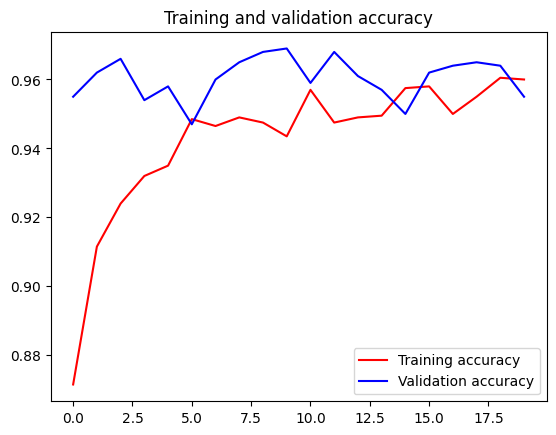

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()